## Approximate Bayesian Computing

Likelihood free method for sampling from posterior distribution. Useful when likelihood is intractable and methods like MCMC are not possible (can't calculate acceptance probability). 

Idea is to sample parameter $\theta$ from prior $\pi(\theta)$ and use sample to generate data from observation model $p(y|\theta)$. Use summary statistics and distance measure to compare simulated $y'$ to true $y$ e.g. $||S(y')-S(y)||$. If distance is less than threshold $\delta$, accept the parameter, otherwise reject and sample again from $\pi(\theta)$. Iterate n times.

Note that this is in R

In [71]:
#generate data from known observation model. select a conjugate prior so the posterior is of the same distribution
#family and can be exactly visualized

#generate data from known negative binomial distribution
#distribution is over the number of failures that occur before reaching target successes
p <- 0.35 #success probability. what we want to estimate
k <- 5 #number of target seccesses. this is known.
n <- 15

y <- rnbinom(n,k,p) #data
s_y <- mean(y) #sufficient statistic

#parameters for beta conjugate prior
a <- 2
b <- 1

#calculate parameters for beta posterior
a_post <- a + k*n
b_post <- b + sum(y)

#get true posterior values to plot
beta_dist <- rbeta(1000000, a_post, b_post)

In [72]:
#function for abc algorithm. delta is threshold. as delta gets smaller, approaches true distribution
abc <- function(t, delta){
    p_sim <- NULL #simulated p
    s_sim <- NULL #simulated sufficient statistics
    for (i in 1:t){
        p_prop <- rbeta(1, a, b)
        y_prop <- rnbinom(n, k, p_prop)
        if (abs(mean(y_prop) - s_y) <= delta){
            p_sim <- append(p_sim, p_prop)
            s_sim <- append(s_sim, mean(y_prop))
        }
        else{
            next
        }
    }
    return(list(p_sim, s_sim))
}

ABC will return an approximation to the posterior distribution. To help reduce variance of the posterior estimates and "shift" the distribution to be closer to the true posterior, a regression correction is used. The simulated $p$ are regressed on the simulated $S(y)$. The regression coefficient $\hat{\beta}$ is then used to correct the distribution with the equation: $p_{rc} = p_{sim} - (S(y)_{sim} - S(y))\hat{\beta}$. This regression correction doesn't do much when delta is small, but in cases of large delta where ABC gives a very off posterior, the correction fixes it a significant amount.

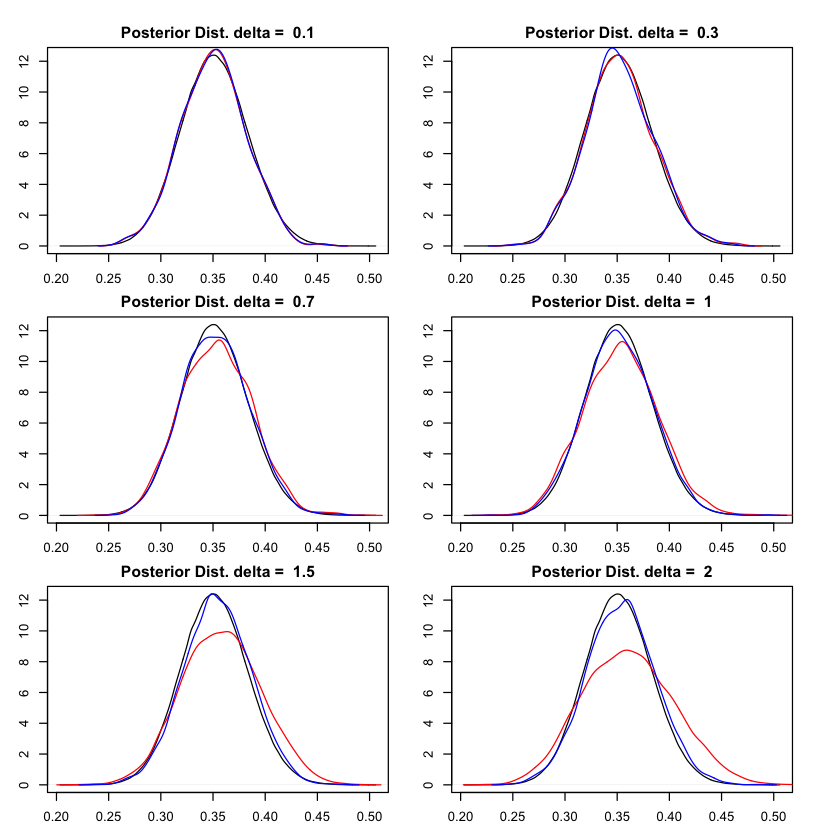

In [75]:
#vary delta to see how posterior is estimated
deltas <- c(0.1, 0.3, 0.7, 1, 1.5, 2)

par(mfrow=c(3,2), oma = c(1,1,1,1), mar = c(2,2,2,2), pty = "m")

for (d in deltas){
    abc_delta <- abc(100000, d)
    #regression correction
    beta_rc <- coef(lm(abc_delta[[1]] ~ abc_delta[[2]]))[2]
    p_rc <- abc_delta[[1]] - beta_rc*(abc_delta[[2]] - s_y)
    plot(density(beta_dist), main = paste('Posterior Dist. delta = ', d), xlab = 'p')
    lines(density(abc_delta[[1]]), col = 'red')
    lines(density(p_rc), col = 'blue')
}

Now try an example with 2 unknown parameters

In [2]:
install.packages("LaplacesDemon")
library(LaplacesDemon)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [45]:
#generate data from a normal distribution. normal-gamma is conjugate
mu <- -1 #mean
tau <- 1 #precision i.e. 1/sd^2
n <- 10

x <- rnormp(n, mu, tau)
s_x <- mean(x) #sufficient statistic
s_sd <- sd(x) #second sufficient statistic

#parameters for normal-gamma prior. make all 1
mu_0 <- 1
nu <- 1
alpha <- 1
beta <- 1
pars <- c(mu_0, 1/nu, alpha, beta)

#parameters for normal-gamma posterior
xbar <- mean(x)

mu_0_post <- (nu*mu_0 + n*xbar)/(nu + n)
nu_post <- nu + n
alpha_post <- alpha + n/2
beta_post <- beta + .5*sum((x - xbar)^2) + ((n*nu)/nu + n)*(((xbar - mu_0)^2)/2)
pars_post <- c(mu_0_post, 1/nu_post, alpha_post, beta_post)

In [4]:
install.packages("nclbayes", repos="http://R-Forge.R-project.org")
library(nclbayes)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


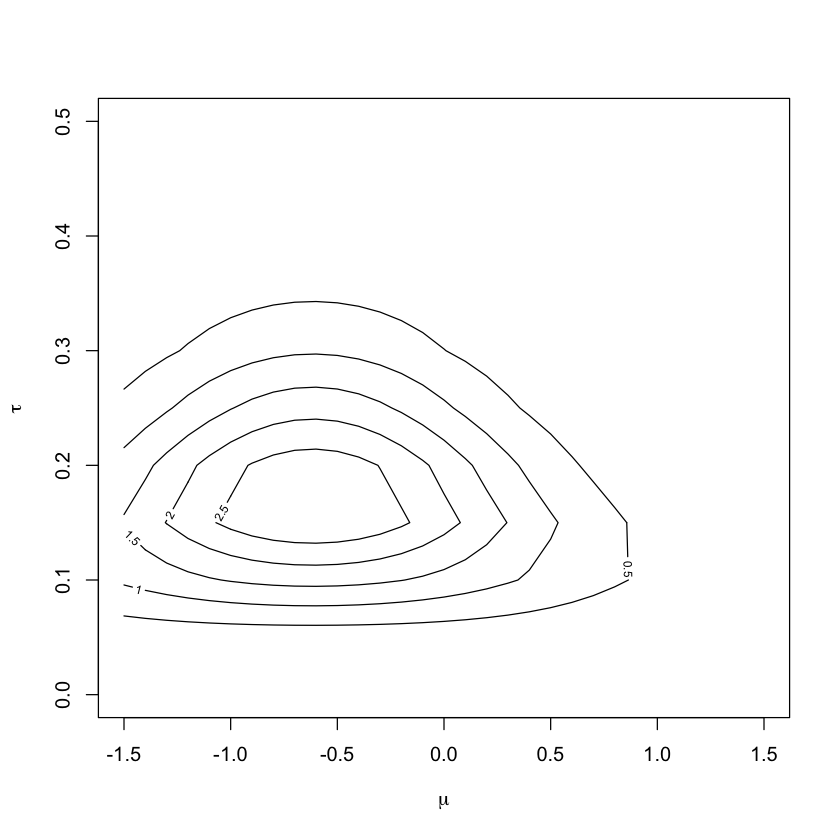

In [83]:
#Posterior in known range
NGacontour(seq(-1.5,1.5,by=0.1), seq(0,0.5,by=0.05), mu_0_post, nu_post, alpha_post, beta_post)

In [12]:
#abc
abc_2d <- function(t, delta){
    mu_sim <- NULL #simulated mean
    tau_sim <- NULL #simulated tau 
    s_sim <- NULL #sufficient statistic
    for (i in 1:t){
        draw <- rnormgamma(1, mu_0, nu, alpha, beta)
        mu_prop <- draw[1]
        tau_prop <- draw[2]
        x_prop <- rnormp(n, mu_prop, tau_prop)
        if (abs(mean(x_prop) - s_x) <= delta){
            mu_sim <- append(mu_sim, mu_prop)
            tau_sim <- append(tau_sim, tau_prop)
            s_sim <- append(s_sim, mean(x_prop))
        }
        else {
            next
        }
    }
    return(list(mu_sim, tau_sim, s_sim))
}

In [47]:
#run abc for delta = 0.1
abc_d1 <- abc_2d(100000, 0.1)

In [49]:
mu_s <- abc_d1[[1]]
tau_s <- abc_d1[[2]]
sf_s <- abc_d1[[3]]

In [57]:
#regression corrections done seperately
beta_rcm <- coef(lm(mu_s ~ sf_s))[2]
mu_rc <- mu_s - beta_rcm*(sf_s - s_x)

beta_rct <- coef(lm(tau_s ~ sf_s))[2]
tau_rc <- tau_s - beta_rct*(sf_s - s_x)

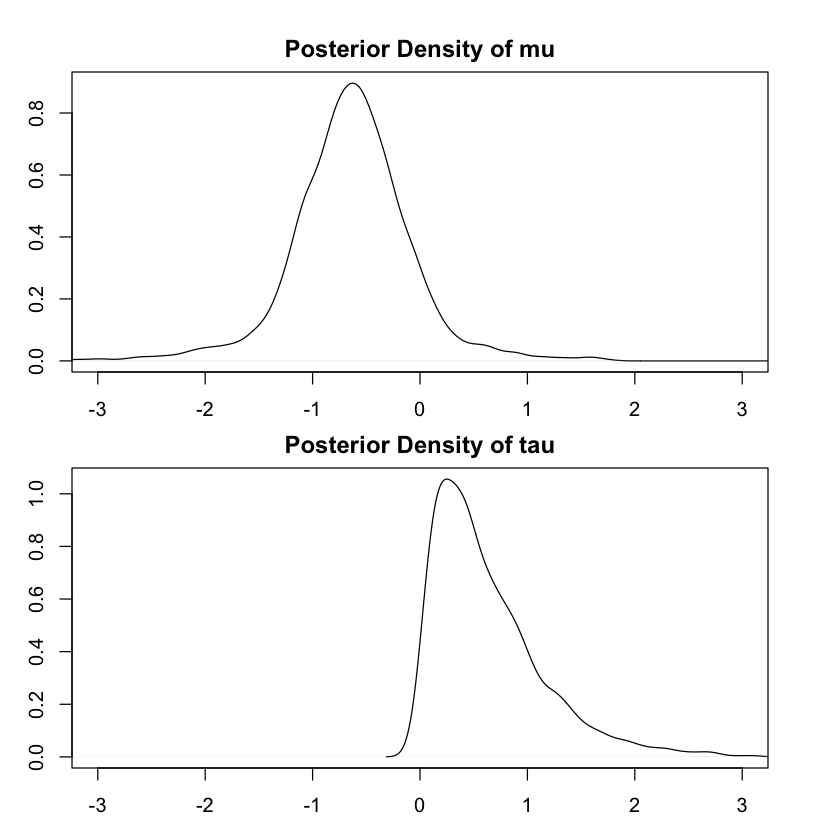

In [86]:
par(mfrow=c(2,1), oma = c(1,1,1,1), mar = c(2,2,2,2), pty = "m")
plot(density(mu_rc), main = 'Posterior Density of mu', xlim = c(-3,3))
plot(density(tau_rc), main = 'Posterior Density of tau', xlim = c(-3,3))